#              Project report of NMR spectrum generator: NMRoss

# Introduction:

Chemistry revolves around molecules. When working in the laboratory, as chemists, it is of utmost importance to know with what molecules we are working with. 1H NMR may be one of the most if not the most important method to know what the product synthetised may be. It allowed through the years to refine the knowledge of chemistry as it is today and will surely be used for years to come. 

1H NMR is based upon different kinds of interaction within a molecule: J coupling, chemical shift coupling, dipole coupling, interactions of the molecule with the solvent and so on.

A proper model of 1H NMR would require quantum calculations and be heavy in electrical brain power. A simplification of this model was brought by a team of researchers : H.M. Bell, L.K. Berry, E.A. Madigan in the paper Org. Magn. Res. ~. 693 (1984). This simplification was that for different kinds of hydrogens, the chemical shift of a carbon can be approximated by what his environnment is and what substituents are on the carbon the hydrogen is bonded to. Along with this knowledge, an easier version of a 1H NMR predictor is possible and it is what was tried in this project. 



The approximations done to the system are: 
1. All hydrogens that are on the same atom have the same shift.
2. The peaks are perfect gaussians.
3. The split between peaks of the same hydrogen is a constant and is the same for every hydrogen.
4. The ratio of height between the different peaks of multiplicity for one hydrogen, is determined by an approximate table made looking at 1H NMR of molecules. This ration is the same for all hydrogen.
5. Only the functional groups that are in a radius of four around an alkyl hydrogen are considered.
6. The shift coupling interactions decrease with a ratio of one over the number of bonds in between, squared.
7. No interactions with the solvent were considered.
8. The multiplicity of hydrogens was calculated by looking at the number of hydrogens on the direct neighboring atoms (wether the shift is equivalent or not), and only if they are a carbon.

# Process of thought:

### I) Alkyl hydrogens:
The function that is most important is NMR(name : str). This function directly or indirectly holds every other function and shows the approximate NMR calculated with the tables of experimental chemical shift. This function works for every coumpounds containing alkyls, maximum one 6 carbon aromatic rings, -O, -N and/or -S hydrogens as long as the functional groups of the chemical are in the table. This function can take as the input either the IUPAC name or the SMILES representation of the compound. 

The multiplicity was calculated independently from the rest and was given for every atom in the molecule which had one hydrogen or more. A dictionnary representing the number of hydrogens on each atom was used intermediatly to have this result. 

For hydrogens on alkyls, the program works with Mol objects and creates a molecular map. This map is a dictionnary with the keys being the index of the atom and the values the distance from a chosen starting atom. The program takes all the branches of the molecule from the starting atom; branches are the substituants of the starting atom until the end of the molecule. These branches are then individually analysed and the functional groups are recognized with the rdkit function GetSubstructMatches(). From all these results, the shift could be calculated using the tables of shift. 


### II) Aromatic hydrogens:
For hydrogens on aromatic carbons, a different logic was used than for the alkyls. The reasoning was that since the program would only consider 6 ringed aromatic carbons, the smiles encoding of the molecules would always have the same format where each aromatic carbon is a 'c' and all substituents of the aromatic ring could be found by looking between the 'c'. Therefore, the first part of the code for aromatic rings is meant to clean the smiles of any useless information taken account of the assumptions (ex: stereochemistry of double bonds, ...etc). Then, once all the aromatic carbon indexes are identified, the subtituents are found by looking in between the indexes which are once again cleaned of extra information (ex : '()'). If there are no substituents, a hydrogen is placed manualy in the string. Finally, the functional groups in each of the substituents is searched with a similar function to GetSubstructMatches() adapted to this specific case. From the matches made in each substituent and their distance from the corresponding aromatic carbon, the shift can be calculated depending on the position relative to the hydrogen that is considered for the calculation. In fact, a dictionary of all the possible subtituents has a tuple of 3 values of affecting shift, each value corresponds to a ortho, meta or para position. At last, the indexes of the aromatic carbons in the smiles are matched to the indexes in the mol object in order to graph the spectrum with NMR().


# Results and limitations:

### I) Alkyl hydrogens:
A problem arose with alkyls, more precisely with secondary carbons in the case of molecules with an aromatic ring and two branches or more on this ring with subbranches on it. The branches given by the algorithm developped were in smiles notation. Most of the time, the smiles given started with the atom chosen and that was what was meant to be, but sometimes unexpectedly it was not the case. This means that it was difficult to know precisely where in the molecule the branch was and the distances were not measured correctly. This resulted in an index out of range error in the search_algo function which unfortunately couldn't be fixed. This error could maybe be debugged doing a maximum similarity method on the molecule with the branch aquired and determine which atom in the branch dimension corresponds to the root atom in the molecule dimension. Alternatively molecular maps could be done for each atom on the branch and the map which corresponds best to the one from the starting atom is defined as the root atom. Both of these methods were tried but were too difficult to code and so this was let in place.




Some pretty good results are obtained nonetheless, for exemple for ethanol:


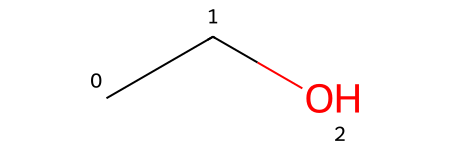

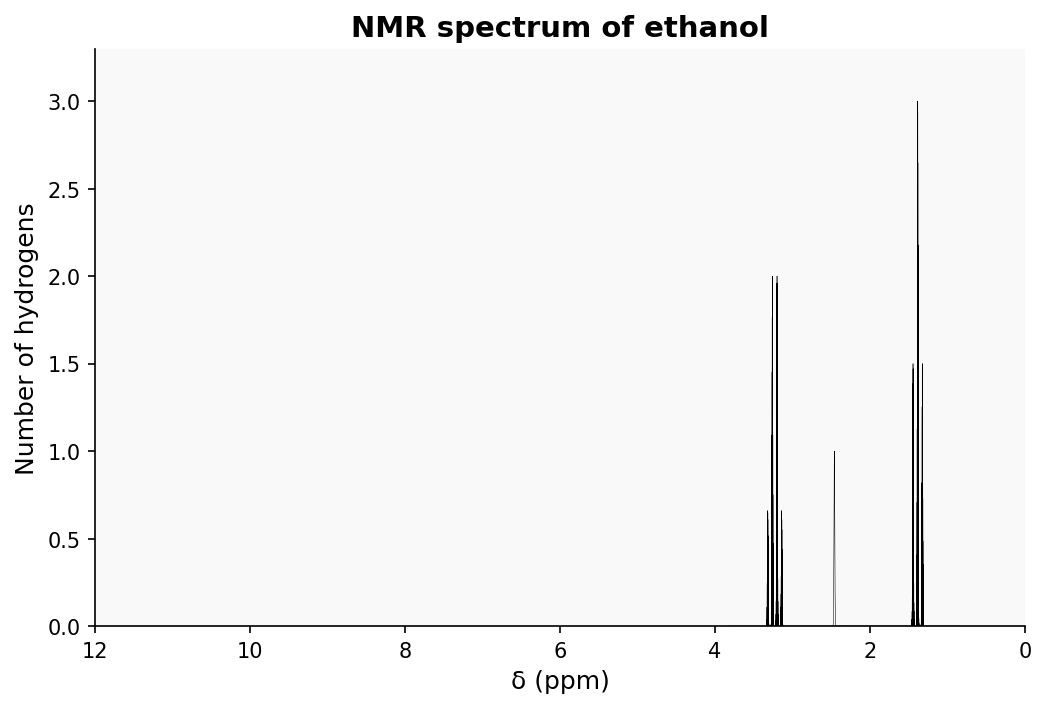

In [1]:
from nmross.NMRoss import NMR
plt, mol = NMR('ethanol')
mol

As mentionned before, the program partially works using the rdkit function GetSubstructMatches(), it is really useful as it allows to know if a functional group of the table is in the molecule and indicates precisely where exactly it is. Sadly, it is as useful as it prevents exact calculations within the approximation. Indeed, it was thought during the developpment of the program that aromatic rings would be a problem because of the different kinds of aromatic rings there are in the table. The shift shouldn’t be the same for the two examples below but yet with the approach of GetSubstructMatches() it is. 

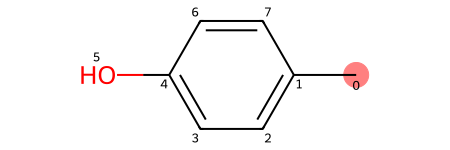

In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
smiles1 = 'Cc1ccc(O)cc1'   
mol1 = Chem.MolFromSmiles(smiles1)
mol1.__sssAtoms = [0]
mol1

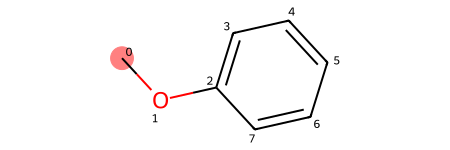

In [4]:
smiles2 = 'COc1ccccc1' 
mol2 = Chem.MolFromSmiles(smiles2)
mol2.__sssAtoms = [0]
mol2

That is why the function clean_aromatics was developped. It was made purposefully to cut off every substituants of every aromatic rings to not have this problem anymore. Indeed, when using clean_aromatics for the first molecule, the molecule stays the same. However, for the second molecule it simply becomes a toluene. 

The problem of GetSubstructMatches() was then observed for non-aromatic substituents. Indeed, this method doesn’t identify the order of the smiles and so it can’t distinguish between esthers bonded from the carbon or from the oxygen.


Another pretty powerful tool made in this project is the Show(name : str, z : int) function which builds on the NMR(name : str) function and highlights in red on the graph the peak belonging to the hydrogen picked and highlights in red on the molecule the atoms with hydrogens that have the same chemical shift as the atom chosen.

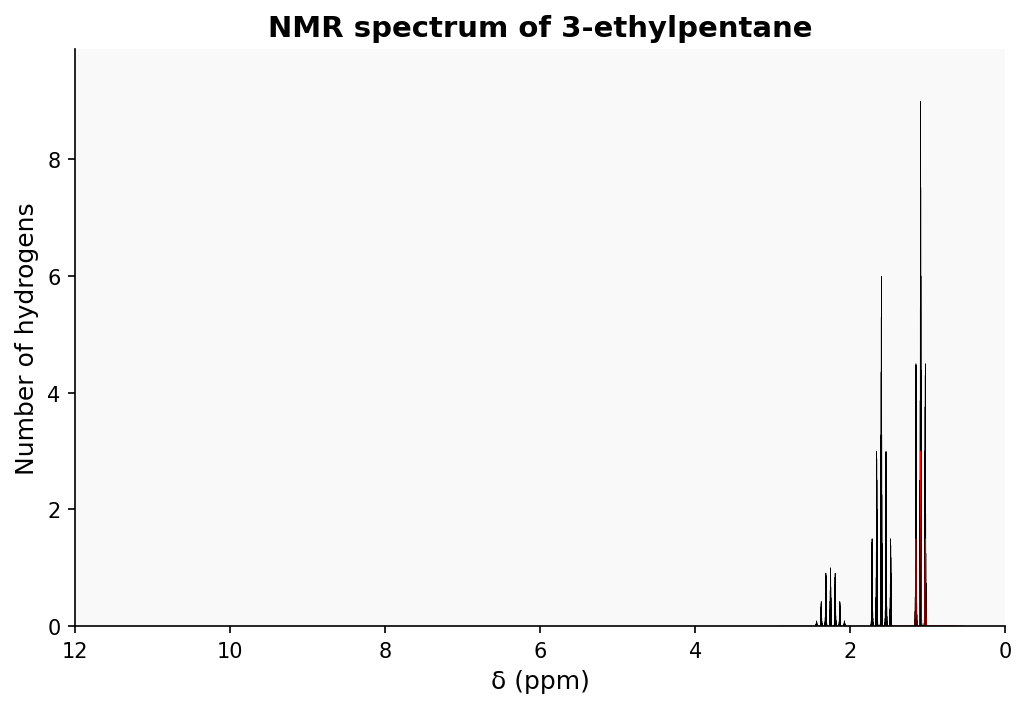

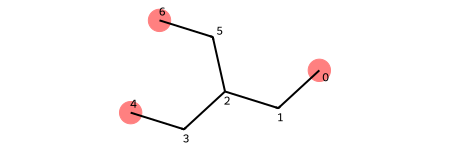

In [12]:
from nmross.NMRoss import NMR, Show
plt, mol = Show('CCC(CC)CC',0)
mol

To have these final functions a lot of intermediate ones were needed. The hardest one was search_algo(index, smiles). That is because of the lack of instructions on as how to do this. Different algorithms were tried but finally thrown away due to a too high complexity. The most promising one was to consider molecules as branches. From a particular atom, different branches can be obtained. The branches from start to end could be compared to the list of substituants. If the branch was not one of the substituants then the furthest atom would be cut off and so on until the branch looked like one of the substituants. Once one was observed, the analysis would start again for the same branch but cutting the group identified before so as to not have doubles. This algorithm would have not had the flaw of the current algorithm but it seemed that it was most complicated to put into operation, especially at intersections or with different lengths subbranches.

### II) Aromatic hydrogens:
First to simplify the calculations for the aromatic case, whenever a molecule contained more than 1 aromatic ring, a function was created to erase any substituents on the aromatic rings that the shift calculation wasn't happening on. Similarly to the alkyl case a clean_aromatic function was made for this purpose. Therefore, when calculations were being done on one aromatic ring, the substituents containing aromatic rings would be reduced to just Ph groups (the functional groups before the aromatic ring would be preserved obviously).
At first look, the results were very satisfying for simple aromatic molecules where there was only one ring. Some examples are presented below: (the exemples also use the alkyl hydrogen code for more complete examples)


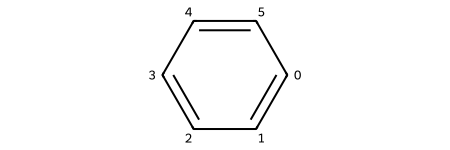

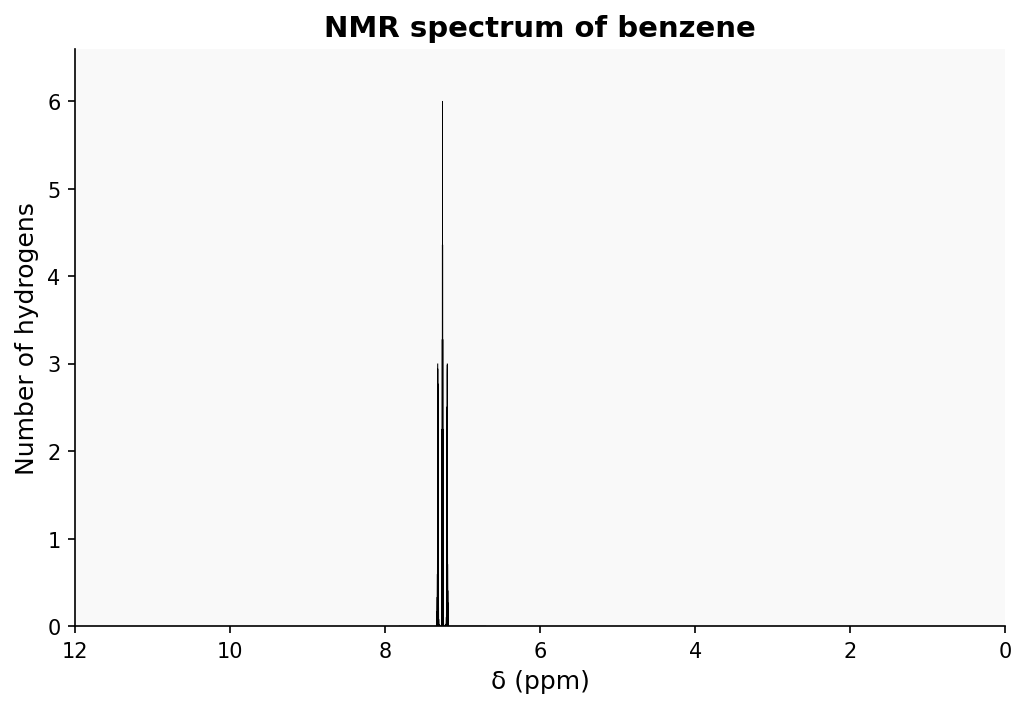

In [40]:
from nmross.NMRoss import NMR
plt, mol = NMR('benzene')
mol

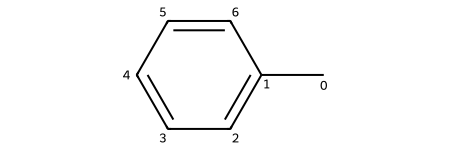

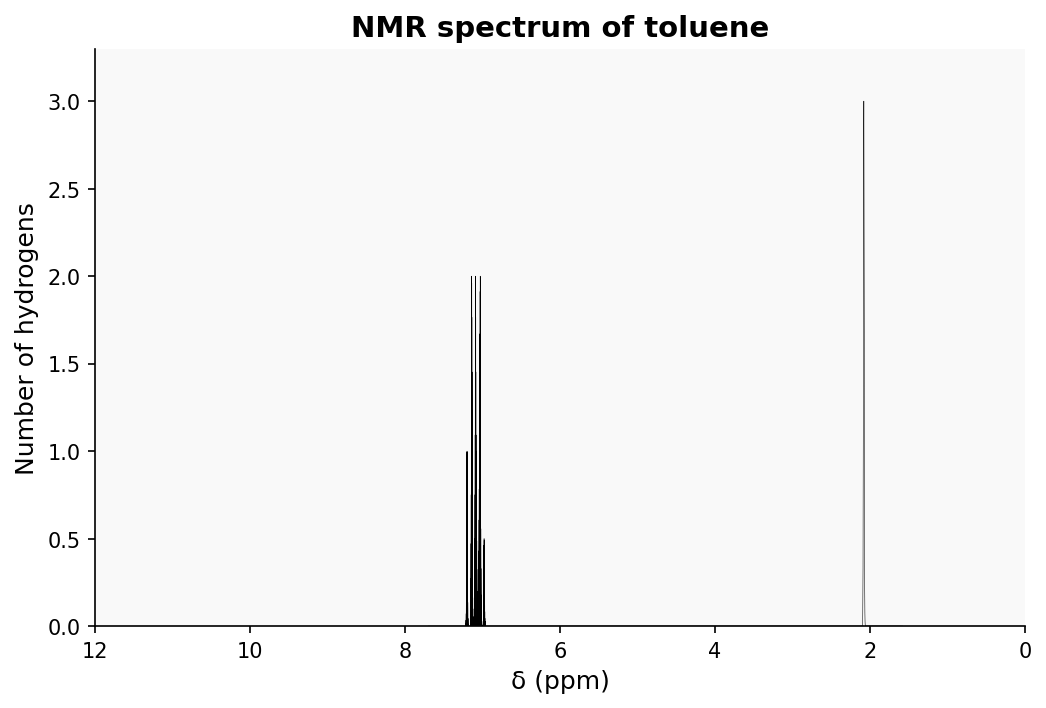

In [41]:
from nmross.NMRoss import NMR
plt, mol = NMR('toluene')
mol

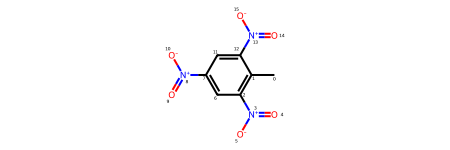

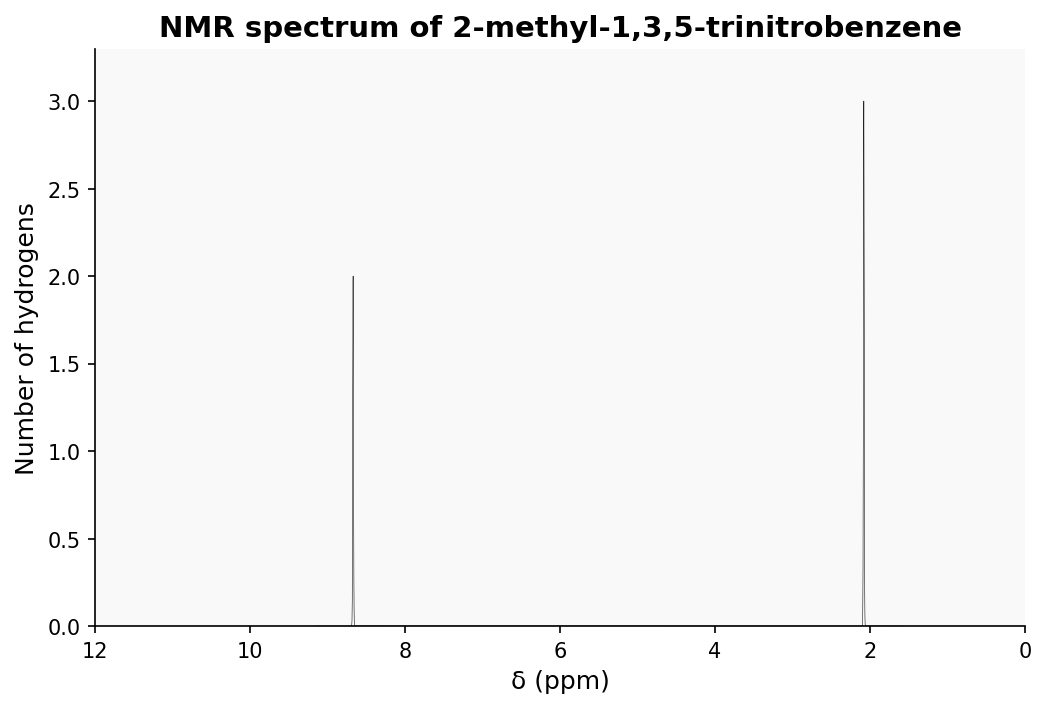

In [44]:
from nmross.NMRoss import NMR
plt, mol = NMR('TNT')
mol

To check that all the results were always correct, intermediate functions were thoroughly tested. Important intermediate functions were search_fctgrps_substituents(), a function that takes in a list of substituants smiles encodings and performs a search for present functional groups, and their distance from the aromatic carbon. Here the results were checked for many kinds of substituents at different distances. calculation_shift_aromatic() was also one of the most important, it would return the shift of all aromatic hydrogens, therefore it was easy to calculate the expected results by hand and compare them to the outputs of the function. Finally, the NMR() function is harder to check since it is difficult to interpret exact results, however we could check if the symmetry of the molecules was respected. For the benzene molecule, we indeed see the expected result of having 6 identical hydrogens at 7.26 ppm (the peak is not a singlet, but a triplet due to approximation 8 made in the introduction). For the TNT case, we see that the two hydrogens form one single peak since they are symmetric. 

The results found for the aromatic hydrogens were satisfying for most molecules, however problems rose whenever the molecule contained two aromatic rings or more. There were some flaws in the logic for treating the aromatic case whenever the smiles encoding of one ring was nested in the other, since the functions to find aromatic carbons and isolate substituents uses the indexes of 'c' in the smiles encoding, the functions were unable to work correctly. This case wasn't initially foreseen, but could have been solved by using a mol object logic or by creating an algorithm to shift the substituants so that the smiles of the aromatic rings were never nested. However due to lack of time to finish the project, it was chosen to simply limit the inputs that the code could take to molecules containing one aromatic ring.   

# Conclusion:

The different algorithms created show that using mol object instead of smiles introduces some level of abstraction but makes the treatement of the molecules easier and allows the use of rdkit functions already made which makes the whole process quite easier.

This predictor was made using an increment based approach. Other ways could have achieved better results but seemed harder in how the algorithm should work and just seemed out of reach.

If the two parts (the alkyls hydrogens and the aromatic hydrogens) are combined, NMR spectrums for rather complex molecules can be generated and look like the NMR one would expect, for example mescaline, a psychedelic hallucinogen derived from the Peyote cactus, that respects every criteria needed.


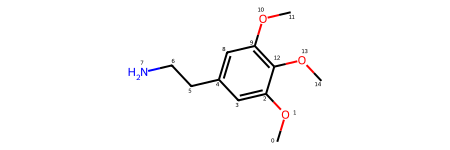

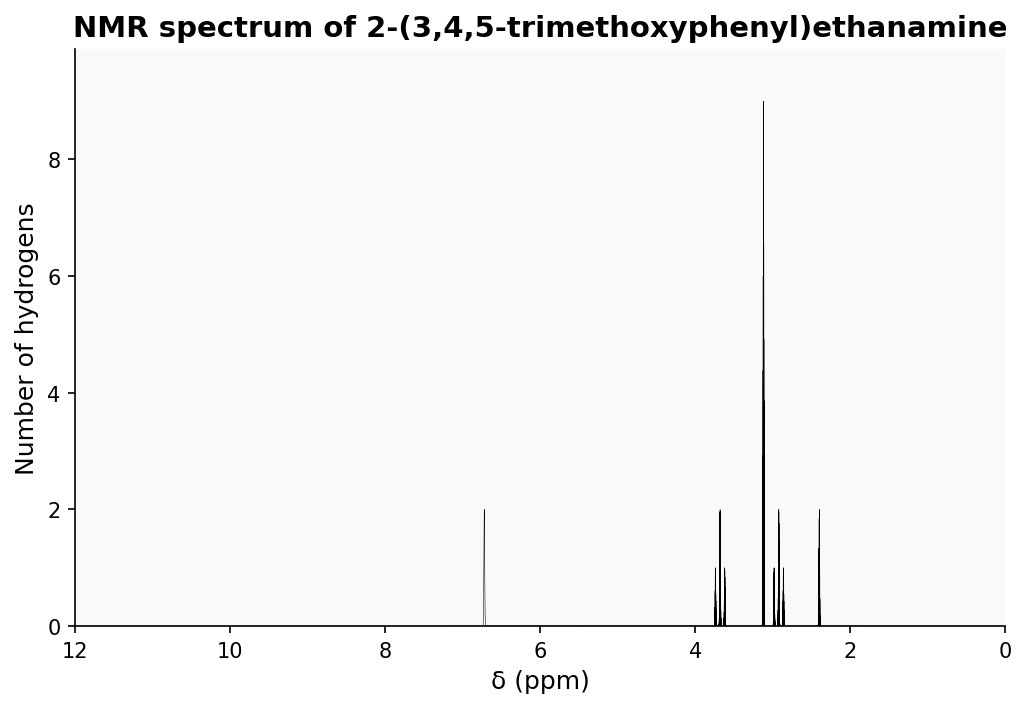

In [13]:
from nmross.NMRoss import NMR
plt, mol = NMR('mescaline')
mol

This project represents around 100 hours of work combined between the two authors. This time was invested thinking about proper algorithms on paper, coding and debugging.